In [3]:
#!pip install torch==1.5.1+cu92 torchvision==0.6.1+cu92 -f https://download.pytorch.org/whl/torch_stable.html --quiet
import torch;print(torch.__version__)

1.6.0


# Import Modules and load pre-trained model

In [15]:
import math,base64
import torch
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

from io import BytesIO

In [14]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Load Model 

In [6]:
class Generator(nn.Module):
    def __init__(self, scale_factor):
        upsample_block_num = int(math.log(scale_factor, 2))

        super(Generator, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.PReLU()
        )
        self.block2 = ResidualBlock(64)
        self.block3 = ResidualBlock(64)
        self.block4 = ResidualBlock(64)
        self.block5 = ResidualBlock(64)
        self.block6 = ResidualBlock(64)
        self.block7 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
        )
        block8 = [UpsampleBLock(64, 2) for _ in range(upsample_block_num)]
        block8.append(nn.Conv2d(64, 3, kernel_size=9, padding=4))
        self.block8 = nn.Sequential(*block8)

    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)
        block6 = self.block6(block5)
        block7 = self.block7(block6)
        block8 = self.block8(block1 + block7)

        return (torch.tanh(block8) + 1) / 2


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(512, 1024, kernel_size=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(1024, 1, kernel_size=1)
        )

    def forward(self, x):
        batch_size = x.size(0)
        return torch.sigmoid(self.net(x).view(batch_size))


class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.prelu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)

        return x + residual


class UpsampleBLock(nn.Module):
    def __init__(self, in_channels, up_scale):
        super(UpsampleBLock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(up_scale)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)
        return x


# load model for inference 

In [7]:
import io,sys 
modelFile = 's8_SRGAN_netG_epoch_2_50.pth'
with open(modelFile, 'rb') as fh: 
    bytestream = io.BytesIO(fh.read()) 

print(f'Model Size: {sys.getsizeof(bytestream) // (1024 * 1024)} MB')

scale_factor = 2
netG = Generator(scale_factor=scale_factor).to(device)
#netD = Discriminator().to(device)

netG.load_state_dict(
    torch.load('s8_SRGAN_netG_epoch_2_50.pth',
               map_location=torch.device('cpu')
    )
)

netG.eval()

Model Size: 2 MB


Generator(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): PReLU(num_parameters=1)
  )
  (block2): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=1)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block3): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=1)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block4): ResidualBlock(
    (conv1)

# Display output from the model

In [8]:
from torchvision.utils import save_image

imgPth = '8300_fb.jpg'
img = Image.open(imgPth)
from torchvision import transforms
img_t = transforms.ToTensor()(img)

with torch.no_grad():
    srimg = netG(img_t.unsqueeze(0)).detach().cpu()
    srimg = srimg[0]
    save_image(srimg, 'fake_SR_image.png')       

# Convert tensor image to numpy array

In [9]:
srimg.unsqueeze(0).size()

torch.Size([1, 3, 448, 448])

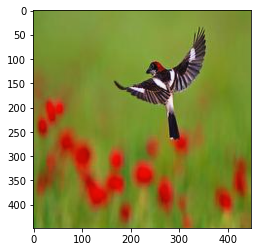

In [10]:
plt.imshow(srimg.permute(1,2,0));

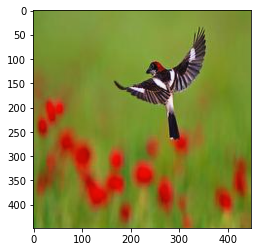

In [11]:
srimg_np = srimg.permute(1,2,0).numpy()
plt.imshow(srimg_np);

# Convert the output image to base64 for deployment

### pil image size is : (448, 448)
### buff is : b''




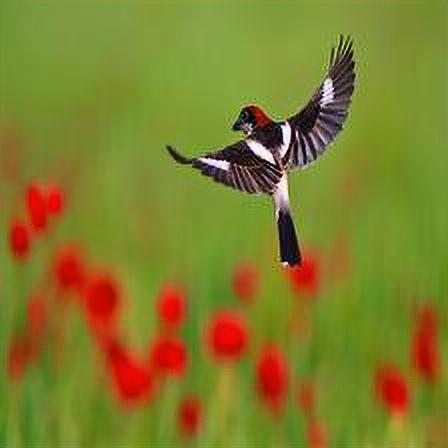

In [12]:
pil_img = Image.fromarray((srimg_np * 255).astype(np.uint8))
#pil_img = Image.fromarray((srimg_np).astype(np.uint8))
buff = BytesIO()
print(f'### pil image size is : {pil_img.size}')

print(f'### buff is : {buff.getvalue()}')
pil_img.save(buff, format="JPEG")
new_image_string = base64.b64encode(buff.getvalue()).decode("utf-8")
img_str = f"data:image/jpeg;base64,{new_image_string}"
print(img_str)

''
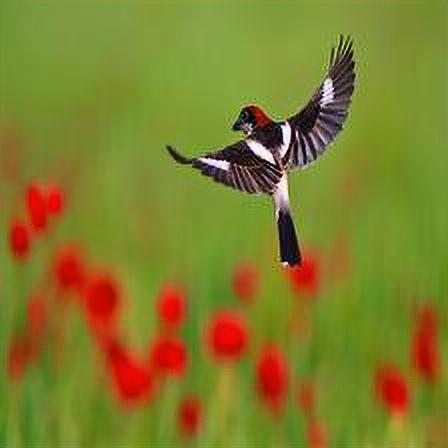

In [13]:
display(img_str)

In [1]:
!pip install torchsummary --quiet

In [ ]:
from torchsummary import summary

summary(netG,input_size=(3,224,224))